# Proyecto Individual 02 de Henry por Guillermo Fernandez

#### Importar librerías necesarias

In [1]:
# Librería para trabajar con los datasets
import pandas as pd
import numpy as np

# Módulo para trabajar con rutas de archivo
from pathlib import Path

# Librería para identificar encondings
import chardet

# Módulo para crear Pipeline
from sklearn.pipeline import Pipeline

# Módulo para procesar y recategorizar
from sklearn import preprocessing as pp

# Módulos para realizar modelos de Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Módulo para evaluar chi2
from scipy import stats

# Módulos para separar los datasets
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

# Módulos para medir los modelos
from sklearn import metrics as met

# Módulo para guardar el pipeline
import joblib

# Librerías para visualizar gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# Módulo para limpiear el resultado de las celdas
from IPython.display import clear_output


#### Crear una función para importar los datasets

In [2]:
# Para importar archivos csv, detectando encoding
def upload(filepath):
    with open(filepath, 'rb') as file:
        result = chardet.detect(file.read())
        DF = pd.read_csv(filepath, encoding=result['encoding'])
    return DF

## EDA

In [3]:
# Cargamos ambos datasets
Train_df = upload(r'C:\Users\eugen\Documents\Guille\Bootcamp\PI02_Datathon\Datasets\hospitalizaciones_train.csv')
Test_df = upload(r'C:\Users\eugen\Documents\Guille\Bootcamp\PI02_Datathon\Datasets\hospitalizaciones_test.csv')

In [4]:
# Aplicamos una función para renombrar las columnas, reemplazando espacios por guión bajo, y aplicando minúsculas
Train_df.rename(lambda x : x.lower().strip().replace(' ','_'), axis = 1, inplace = True)
Test_df.rename(lambda x : x.lower().strip().replace(' ','_'), axis = 1, inplace = True)

In [5]:
# Guardamos el original y trabajamos con una copia
Train_original = Train_df.copy()
Test_original = Test_df.copy()

In [6]:
# Tomamos una fila al azar para analizarlo
Train_df.sample(1)

,available_extra_rooms_in_hospital,department,ward_facility_code,doctor_name,staff_available,patientid,age,gender,type_of_admission,severity_of_illness,health_conditions,visitors_with_patient,insurance,admission_deposit,stay_(in_days)
386079,2,anesthesia,A,Dr Mark,9,126702,61-70,Male,Trauma,Extreme,Diabetes,2,Yes,6538.146038,32


In [7]:
Test_df.sample(1)

,available_extra_rooms_in_hospital,department,ward_facility_code,doctor_name,staff_available,patientid,age,gender,type_of_admission,severity_of_illness,health_conditions,visitors_with_patient,insurance,admission_deposit
57691,4,gynecology,F,Dr Olivia,4,120159,21-30,Female,Emergency,Moderate,None,4,Yes,5289.388733


In [8]:
# Evaluamos información del dataset, como Dtype y nulos
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   available_extra_rooms_in_hospital  410000 non-null  int64  
 1   department                         410000 non-null  object 
 2   ward_facility_code                 410000 non-null  object 
 3   doctor_name                        410000 non-null  object 
 4   staff_available                    410000 non-null  int64  
 5   patientid                          410000 non-null  int64  
 6   age                                410000 non-null  object 
 7   gender                             410000 non-null  object 
 8   type_of_admission                  410000 non-null  object 
 9   severity_of_illness                410000 non-null  object 
 10  health_conditions                  410000 non-null  object 
 11  visitors_with_patient              4100

In [9]:
Test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   available_extra_rooms_in_hospital  90000 non-null  int64  
 1   department                         90000 non-null  object 
 2   ward_facility_code                 90000 non-null  object 
 3   doctor_name                        90000 non-null  object 
 4   staff_available                    90000 non-null  int64  
 5   patientid                          90000 non-null  int64  
 6   age                                90000 non-null  object 
 7   gender                             90000 non-null  object 
 8   type_of_admission                  90000 non-null  object 
 9   severity_of_illness                90000 non-null  object 
 10  health_conditions                  90000 non-null  object 
 11  visitors_with_patient              90000 non-null  int

## Data Preprocessing

#### Feature relevante

In [10]:
# Eliminamos los datos duplicados
Train_df.drop_duplicates();
Test_df.drop_duplicates();

In [11]:
# Agregamos el feature que nos interesa predecir, si la estadía es prolongada
Train_df['long_stay'] = (Train_df['stay_(in_days)'] > 8)
Train_df['long_stay'].astype(str).replace({False: 0, True: 1})
Train_df['long_stay'] = Train_df['long_stay'].astype(int)
# Dropeamos la columna 'stay_(in_days)' para evitar redundancia
Train_df.drop(columns='stay_(in_days)', inplace=True);

In [12]:
Train_df.sample(1)

,available_extra_rooms_in_hospital,department,ward_facility_code,doctor_name,staff_available,patientid,age,gender,type_of_admission,severity_of_illness,health_conditions,visitors_with_patient,insurance,admission_deposit,long_stay
111193,3,radiotherapy,E,Dr Sam,8,128836,31-40,Male,Urgent,Moderate,Other,2,Yes,4252.035141,0


In [13]:
# Revisamos la cantidad de valores del feature agregado
Train_df.long_stay.value_counts()

1    255416
0    154584
Name: long_stay, dtype: int64

### Analizar correlación de acuerdo al P valor

In [14]:
# Tomamos los nombres de todas las columnas
list(Train_df.columns)[:-1];

In [15]:
# Evaluamos la correlación con la feature seleccionada de cada otra feature (no numérica)
for elem in list(Train_df.columns)[:-1]:
    P_valor = stats.chi2_contingency(np.array(pd.crosstab(Train_df[elem], Train_df.long_stay)))[1]
    print(f'{elem}: {P_valor}')

available_extra_rooms_in_hospital: 0.0
department: 0.0
ward_facility_code: 0.0
doctor_name: 0.0
staff_available: 0.027185032657605284
patientid: 0.29157056421547367
age: 0.0
gender: 0.0
type_of_admission: 1.6947748596830503e-21
severity_of_illness: 2.875013724138087e-130
health_conditions: 5.6584831831517945e-09
visitors_with_patient: 0.0
insurance: 0.4988221951889673
admission_deposit: 0.49327701140734725


In [16]:
# Evaluamos la correlación con features numéricas
Train_df.corr()

,available_extra_rooms_in_hospital,staff_available,patientid,visitors_with_patient,admission_deposit,long_stay
available_extra_rooms_in_hospital,1.000000,-0.003064,-0.005426,0.071073,-0.050775,0.053894
staff_available,-0.003064,1.000000,-0.000350,0.001444,0.000816,0.002883
patientid,-0.005426,-0.000350,1.000000,-0.006393,0.011602,-0.000532
visitors_with_patient,0.071073,0.001444,-0.006393,1.000000,-0.069566,-0.009529
admission_deposit,-0.050775,0.000816,0.011602,-0.069566,1.000000,-0.016650
long_stay,0.053894,0.002883,-0.000532,-0.009529,-0.016650,1.000000


### Realizar tratamiento de features

##### Se eliminan columnas que no tienen significado numérico y presentan ninguna correlación

In [17]:
# patientid no tiene significado numérico, insurance no tiene correlación
Train_df.drop(columns=['patientid', 'insurance'], inplace=True)
Test_df.drop(columns=['patientid', 'insurance'], inplace=True)

In [18]:
# Revisamos que las features en ambos datasets sean iguales
for elem in list(Test_df.columns):
    print(f'{elem}')
    unicos_train, unicos_test = Train_df[elem].sort_values().unique(), Test_df[elem].sort_values().unique()
    print(f'        Train: {len(unicos_train)} {unicos_train}')
    print(f'        Test:  {len(unicos_test)} {unicos_test}')
    print(f'Son iguales: {unicos_test.all() == unicos_train.all()}')

available_extra_rooms_in_hospital
        Train: 18 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 24]
        Test:  18 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 24]
Son iguales: True
department
        Train: 5 ['TB & Chest disease' 'anesthesia' 'gynecology' 'radiotherapy' 'surgery']
        Test:  5 ['TB & Chest disease' 'anesthesia' 'gynecology' 'radiotherapy' 'surgery']
Son iguales: True
ward_facility_code
        Train: 6 ['A' 'B' 'C' 'D' 'E' 'F']
        Test:  6 ['A' 'B' 'C' 'D' 'E' 'F']
Son iguales: True
doctor_name
        Train: 9 ['Dr Isaac' 'Dr John' 'Dr Mark' 'Dr Nathan' 'Dr Olivia' 'Dr Sam'
 'Dr Sarah' 'Dr Simon' 'Dr Sophia']
        Test:  9 ['Dr Isaac' 'Dr John' 'Dr Mark' 'Dr Nathan' 'Dr Olivia' 'Dr Sam'
 'Dr Sarah' 'Dr Simon' 'Dr Sophia']
Son iguales: True
staff_available
        Train: 11 [ 0  1  2  3  4  5  6  7  8  9 10]
        Test:  11 [ 0  1  2  3  4  5  6  7  8  9 10]
Son iguales: True
age
        Train: 10 ['0-10' '11-20' '21-30' '31-40' '41-50

#### Recategorizar las variables

In [19]:
# Utilizamos OneHotEncoder para modificar variables categóricas
OHE = pp.OneHotEncoder(categories='auto')
# Aplicamos a las columnas categóricas
OHE_df = OHE.fit_transform(Train_df[['department', 'ward_facility_code', 'doctor_name', 'gender',
                                     'type_of_admission', 'health_conditions']]).toarray()

In [20]:
# Transformamos y unimos al DF original
OHE_df = pd.DataFrame(OHE_df, columns=OHE.get_feature_names_out())
Train_df = pd.concat([Train_df, OHE_df], axis=1)

In [21]:
# Se eliminan las columnas que fueron transformadas
Train_df.drop(columns = ['department', 'ward_facility_code', 'doctor_name', 'gender',
                         'type_of_admission', 'health_conditions'], inplace = True)

In [22]:
# Ahora hacemos similar pero con OrdinalEncoder
ORE = pp.OrdinalEncoder()
Train_df.age = ORE.fit_transform(Train_df[['age']])
Train_df.severity_of_illness = ORE.fit_transform(Train_df[['severity_of_illness']])

In [23]:
Train_df.sample(1)

,available_extra_rooms_in_hospital,staff_available,age,severity_of_illness,visitors_with_patient,admission_deposit,long_stay,department_TB & Chest disease,department_anesthesia,department_gynecology,...,gender_Other,type_of_admission_Emergency,type_of_admission_Trauma,type_of_admission_Urgent,health_conditions_Asthama,health_conditions_Diabetes,health_conditions_Heart disease,health_conditions_High Blood Pressure,health_conditions_None,health_conditions_Other
354320,3,5,3.0,2.0,4,3834.061982,1,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
# Repetimos para el set de testeo
OHE_df = OHE.fit_transform(Test_df[['department', 'ward_facility_code', 'doctor_name', 'gender',
                                     'type_of_admission', 'health_conditions']]).toarray()
OHE_df = pd.DataFrame(OHE_df, columns=OHE.get_feature_names_out())
Test_df = pd.concat([Test_df, OHE_df], axis=1)
Test_df.drop(columns = ['department', 'ward_facility_code', 'doctor_name', 'gender',
                         'type_of_admission', 'health_conditions'], inplace = True)
Test_df.age = ORE.fit_transform(Test_df[['age']])
Test_df.severity_of_illness = ORE.fit_transform(Test_df[['severity_of_illness']])


## Pipeline

In [87]:
# Separamos los datos para realizar el entrenamiento de modelos
X = Train_df.drop(columns=['long_stay'])
y = Train_df.long_stay
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = 0.2, random_state=21)

In [76]:
# Instanciamos diferentes Pipelines para los distintos modelos que buscamos evaluar 
LR_Pipe = Pipeline([("scl", pp.StandardScaler()),
                    ("LR", LogisticRegression(random_state=21))])

KNN_Pipe = Pipeline([("scl", pp.StandardScaler()),
                     ("KNN", KNeighborsClassifier())])

Tree_Pipe = Pipeline([("scl", pp.StandardScaler()),
                      ("Tree", DecisionTreeClassifier(random_state=21))])

RF_Pipe = Pipeline([("scl", pp.StandardScaler()),
                      ("Tree", RandomForestClassifier(random_state=21))])

In [77]:
# Creamos la lista y el diccionario para las iteraciones e identificaciones
pipelines = [LR_Pipe, KNN_Pipe, Tree_Pipe, RF_Pipe]
pipe_dict = {0: "LogisticRegression", 1: "KNeighborsClassifier", 2: "DecisionTreeClassifier", 3: 'RandomForestClassifier'}

In [78]:
# Entrenamos los diferentes modelos
for cant, pipe in enumerate(pipelines, start=1):
    pipe.fit(X_Train,Y_Train)
    clear_output(wait=True)
    print(f'{cant} modelo/s entrenado/s!')

4 modelo/s entrenado/s!


In [79]:
# Evaluamos los resultados de los distintos modelos e identificamos el mejor
best_acc, best_clf, best_pipe = 0.0, 0, ''
for idx, val in enumerate(pipelines):
	score = val.score(X_Test, Y_Test)
	if score > best_acc:
		best_acc, best_pipe, best_clf = score, val, idx
	print(f'{pipe_dict[idx]} pipeline accuracy en test: {score}')
print(f'El modelo con el mejor accuracy es: {pipe_dict[best_clf]}')

LogisticRegression pipeline accuracy en test: 0.6034634146341463
KNeighborsClassifier pipeline accuracy en test: 0.7080487804878048
DecisionTreeClassifier pipeline accuracy en test: 0.7701219512195122
RandomForestClassifier pipeline accuracy en test: 0.7582682926829268
El modelo con el mejor accuracy es: DecisionTreeClassifier


DecisionTreeClassifier pipeline accuracy en test: 0.7701219512195122 (versión con Test size 0.20 y Random State 21)

In [80]:
# Guardamos el pipeline en un archivo
joblib.dump(best_pipe, 'Mejor_pipeline.pkl', compress=1)
print(f'Pipeline de {pipe_dict[best_clf]} guardado a archivo')

Pipeline de DecisionTreeClassifier guardado a archivo


## Modelado - Árbol de desición

Se eligió el árbol de desición debido a que fue el que mejor resultado dió en el pipeline

### Identificar la profundidad

In [94]:
# Realizamos una iteración para evaluar la profundidad óptima del árbol
tree_train_scores_mean = []
tree_train_scores_std = []
# Iniciamos listas para guardar los valores
tree_test_scores_mean = []
tree_test_scores_std = []
# Consideramos 20 como profundidad máxima
profundidades = np.arange(1,21,1)

for profundidad in profundidades:
    # Instanciamos el arbol
    clf = DecisionTreeClassifier(max_depth=profundidad,criterion="entropy")
    # Realizamos tres pruebas gracias al metodo cross_validate
    tree_scores = cross_validate(clf, X, y, cv=3, return_train_score=True, n_jobs = -1)
    # Guardamos los valores tanto del entrenamiento como del test
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())
    clear_output(wait=True)
    print(f'Arbol de profundidad {profundidad} entrenado!')
#Transformamos los valores para poder graficarlos
tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

Arbol de profundidad 20 entrenado!


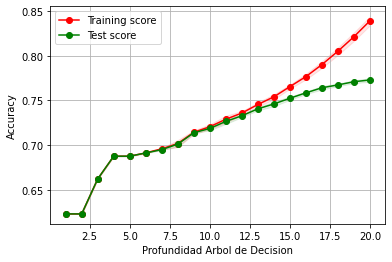

In [95]:
# Ploteamos los resultados
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

### Medir rendimiento de la profundidad óptima

In [90]:
clf = DecisionTreeClassifier(max_depth=15,criterion="entropy")
clf.fit(X_Train.values, Y_Train.values)
Y_pred = clf.predict(X_Test.values)
print(met.classification_report(Y_Test, Y_pred))

              precision    recall  f1-score   support

           0       0.68      0.65      0.66     30977
           1       0.79      0.82      0.80     51023

    accuracy                           0.75     82000
   macro avg       0.74      0.73      0.73     82000
weighted avg       0.75      0.75      0.75     82000



array([[19993, 10984],
       [ 9393, 41630]], dtype=int64)

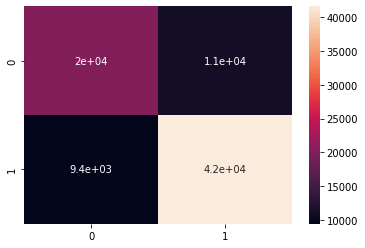

In [91]:
sns.heatmap(met.confusion_matrix(Y_Test, Y_pred),annot=True)
met.confusion_matrix(Y_Test, Y_pred)

### Rendimiento del modelo arrojado por el pipeline

In [92]:
best_pipe = joblib.load('Mejor_pipeline.pkl')
best_pipe.fit(X_Train.values, Y_Train.values)
Y_pred = best_pipe.predict(X_Test.values)
print(met.classification_report(Y_Test, Y_pred))

              precision    recall  f1-score   support

           0       0.70      0.69      0.70     30977
           1       0.81      0.82      0.82     51023

    accuracy                           0.77     82000
   macro avg       0.76      0.76      0.76     82000
weighted avg       0.77      0.77      0.77     82000



array([[21506,  9471],
       [ 9379, 41644]], dtype=int64)

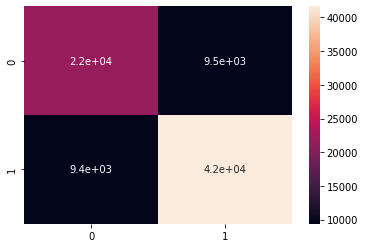

In [93]:
sns.heatmap(met.confusion_matrix(Y_Test, Y_pred),annot=True)
met.confusion_matrix(Y_Test, Y_pred)

Como podemos observar, el modelo entregado por el pipeline es más equilibrado

In [ ]:
# Como adicional, queremos saber qué features fueron las que le sirvieron al árbol, y cuáles se podrían haber eliminado
pd.Series(clf.feature_importances_, index = X_Test.columns).sort_values(ascending = False)

age                                      0.577983
department_anesthesia                    0.104292
admission_deposit                        0.095305
department_radiotherapy                  0.052686
available_extra_rooms_in_hospital        0.052098
department_gynecology                    0.042414
visitors_with_patient                    0.021413
severity_of_illness                      0.012314
type_of_admission_Trauma                 0.010114
type_of_admission_Emergency              0.009723
ward_facility_code_F                     0.006765
ward_facility_code_B                     0.002848
ward_facility_code_D                     0.002261
staff_available                          0.001759
type_of_admission_Urgent                 0.001646
doctor_name_Dr Olivia                    0.001311
doctor_name_Dr Nathan                    0.000962
doctor_name_Dr Sarah                     0.000742
department_surgery                       0.000638
health_conditions_Asthama                0.000436


<AxesSubplot:>

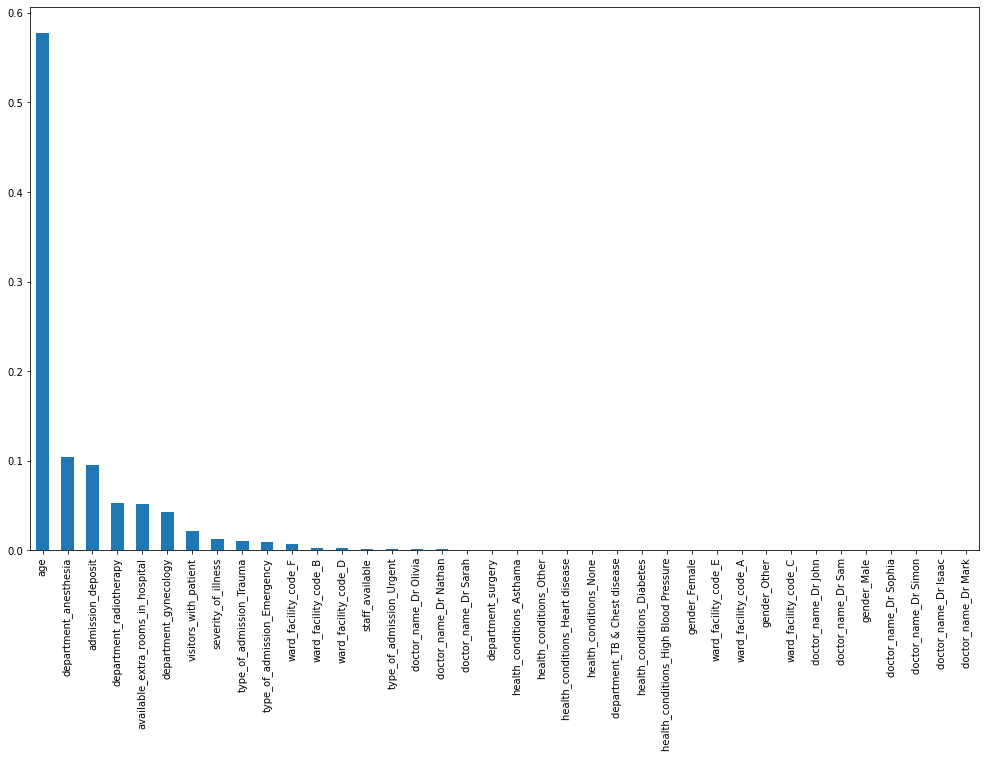

In [ ]:
# Ploteamos la importancia de los atributos elegidos a la hora de hacer la predicción
pd.Series(clf.feature_importances_, index = X_Test.columns).sort_values(ascending = False).plot(kind = 'bar', figsize = (17,10))

Este gráfico nos muestra que el árbol podría hacerse con 6 features con un resultado muy similar

## Predicción

In [ ]:
# Realizamos la predicción para el dataset Test
X = Test_df
y_pred = best_pipe.predict(X.values)

In [ ]:
# Evaluamos la cantidad de datos
y_pred.shape

(90000,)

In [ ]:
# Asignamos los datos al dataset
Test_df['pred'] = y_pred

In [ ]:
# Revisamos los resultados obtenidos
Test_df.sample(5)

,available_extra_rooms_in_hospital,staff_available,age,severity_of_illness,visitors_with_patient,admission_deposit,department_TB & Chest disease,department_anesthesia,department_gynecology,department_radiotherapy,...,type_of_admission_Emergency,type_of_admission_Trauma,type_of_admission_Urgent,health_conditions_Asthama,health_conditions_Diabetes,health_conditions_Heart disease,health_conditions_High Blood Pressure,health_conditions_None,health_conditions_Other,pred
78649,4,0,5.0,2.0,4,3730.435418,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
33201,4,1,1.0,1.0,4,3137.945146,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1089,3,6,2.0,1.0,3,4304.953895,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2409,5,1,4.0,1.0,7,5827.387312,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
51935,3,6,1.0,1.0,4,4770.511192,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
# Contamos la cantidad de resultados
Test_df.pred.value_counts()

1    56121
0    33879
Name: pred, dtype: int64

In [ ]:
# Tomamos únicamente la columna con las predicciones
result = Test_df.pred

In [ ]:
# Exportamos la columna a un csv de acuerdo a la consigna del proyecto
result.to_csv(r'C:\Users\eugen\Documents\Guille\Bootcamp\PI02_Datathon\Datasets\fernandezguille.csv', index=False)

## Conclusiones finales

Luego de realizar varias pruebas, con diferentes métodos (dummies, OHE, LE, ORE), este modelo fue el que mejor accuracy y recall tuvo, sin tener overfitting.  
Muchas de las columnas tenían una relación con la estadía, como se vió con el P_valor, pero el resultado solo mejora un poco a comparación de realizar el árbol con sólo 3 features. Esto se ve muchísimo en el gráfico que mide el peso de las mismas.
Al recibir el feedback del modelo, los valores logrados de las métricas son:
+ Accuracy: 0.7656
+ Recall:   0.8124